In [5]:
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector
from scipy.linalg import expm

Lx, Ly = (3, 3)
L = Lx*Ly
t = 0.25
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4

perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
#perms_v = [[0, 1, 2, 3], [1, 0, 3, 2]]
#perms_h = [[0, 2, 1, 3], [2, 0, 3, 1]]

"""perms_v = [[0, 1, 4, 5, 8, 9, 12, 13, 2, 3, 6, 7, 10, 11, 14, 15], 
          [1, 2, 5, 6, 9, 10, 13, 14, 3, 0, 7, 4, 11, 8, 15, 12]]
perms_h = [[0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15],
          [4, 8, 5, 9, 6, 10, 7, 11, 12, 0, 13, 1, 14, 2, 15, 3]]"""

"""Vlist_H = [expm(-1j*t*hloc1/8), expm(-1j*t*hloc2/4), expm(-1j*t*hloc1/4), expm(-1j*t*hloc2/4), expm(-1j*t*hloc1/8)]
Vlist_V = [expm(-1j*t*hloc1/16), expm(-1j*t*hloc2/8), expm(-1j*t*hloc1/8), expm(-1j*t*hloc2/8), expm(-1j*t*hloc1/16)]
Vlist_start    = Vlist_V + Vlist_H + Vlist_H + Vlist_H + Vlist_V
perms_extended = [perms_v]*5 + [perms_h]*5 + [perms_v]*5 + [perms_h]*5 + [perms_v]*5"""

Vlist_H = [expm(-1j*t*hloc1/2) , expm(-1j*t*hloc2), expm(-1j*t*hloc1/2)]
Vlist_V = [expm(-1j*t*hloc1/4), expm(-1j*t*hloc2/2), expm(-1j*t*hloc1/4)]
Vlist_start    = Vlist_V + Vlist_H + Vlist_V
perms_extended = [perms_v]*3 + [perms_h]*3 + [perms_v]*3

#U = scipy.linalg.expm(-1j*hamil.toarray()*t)
#print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_2D(Vlist_start, L, perms_extended) - U, ord=2) ))
state = np.array(random_statevector(2**L).data)
print("Trotter error: ", np.linalg.norm(ansatz_sparse(Vlist_start, L, perms_extended, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))

Trotter error:  0.13894947679845168


In [ ]:
from optimize_sparse import optimize

Vlist, f_iter, err_iter = optimize(L, hamil, t, Vlist_start, perms_extended, niter=10, rS=16)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [9]:
# Numerical Test function for: d/G_j d/dG_i f(G)
import sys
from utils_sparse import real_to_antisymm, project_unitary_tangent


def numerical_hessian(Glist, Uv, state, L, perms, i, j, epsilon=1e-6):
    """Numerically compute d/dW1 of projected gradient dL/dV1 (Riemannian)."""
    numerical_H = []

    for _ in range(16):
        Z_real = np.zeros(16)
        Z_real[_] = 1.0
        Z = real_to_antisymm(Z_real.reshape(4, 4))  # 4x4 anti-Hermitian direction

        Gj_plus  = Glist[j] @ scipy.linalg.expm(+epsilon*Z)
        Gj_minus = Glist[j] @ scipy.linalg.expm(-epsilon*Z)
    
        if i==j:
            grad_plus  = ansatz_sparse_grad_vector(Glist[:j]+[Gj_plus]+Glist[j+1:], L, Uv, state, perms, unprojected=True, flatten=False)[i]
            grad_minus = ansatz_sparse_grad_vector(Glist[:j]+[Gj_minus]+Glist[j+1:], L, Uv, state, perms, unprojected=True, flatten=False)[i]
            dgrad = (grad_plus - grad_minus) / (2 * epsilon)  # shape (16,)
            G = dgrad.reshape(4, 4)

            V = Glist[j]
            Z = V @ Z
            G = project_unitary_tangent(V, G)
            grad = ansatz_sparse_grad_vector(Glist, L, Uv, state, perms, flatten=False, unprojected=True)[i]
            G -= 0.5 * (Z @ grad.conj().T @ V + V @ grad.conj().T @ Z)
            if not np.allclose(Z, project_unitary_tangent(V, Z)):
                G -= 0.5 * (Z @ V.conj().T + V @ Z.conj().T) @ grad
            G = antisymm_to_real(antisymm( V.conj().T @ G ))
        else:
            grad_plus  = ansatz_sparse_grad_vector(Glist[:j]+[Gj_plus]+Glist[j+1:], L, Uv, state, perms, unprojected=False, flatten=False)[i]
            grad_minus = ansatz_sparse_grad_vector(Glist[:j]+[Gj_minus]+Glist[j+1:], L, Uv, state, perms, unprojected=False, flatten=False)[i]
            dgrad = (grad_plus - grad_minus) / (2 * epsilon)  # shape (16,)
            G = dgrad.reshape(4, 4)
            
        numerical_H.append(G)
    
    return np.array(numerical_H)  # shape: (16, 4, 4)


In [10]:
def grad_numerical(Glist, perms, Uv, v, epsilon=1e-6, flatten=True, unprojected=False):
    grads = []
    for _ in range(len(Glist)):
        W = Glist[_]
        d = Glist[_].shape[0]
        grad_complex = np.zeros((d, d), dtype=complex)

        for i in range(d):
            for j in range(d):
                # Real perturbation
                dW_real = np.zeros_like(W, dtype=complex)
                dW_real[i, j] = epsilon

                Glist_plus_real  = Glist[:_] + [W + dW_real] + Glist[_+1:]
                Glist_minus_real = Glist[:_] + [W - dW_real] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_real, Uv, v, L, perms)
                f_minus = f(Glist_minus_real, Uv, v, L, perms)
                df_real = (f_plus - f_minus) / (2 * epsilon)

                # Imaginary perturbation
                dW_imag = np.zeros_like(W, dtype=complex)
                dW_imag[i, j] = 1j * epsilon

                Glist_plus_imag  = Glist[:_] + [W + dW_imag] + Glist[_+1:]
                Glist_minus_imag = Glist[:_] + [W - dW_imag] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_imag, Uv, v, L, perms)
                f_minus = f(Glist_minus_imag, Uv, v, L, perms)
                df_imag = (f_plus - f_minus) / (2 * epsilon)
    
                grad_complex[i, j] = df_real + 1j * df_imag
        grads.append(grad_complex)

    if unprojected:
        return grads
    
    stack = np.stack([ antisymm_to_real(antisymm(W.conj().T @ grads[j])) for j, W in enumerate(Glist)])
    if flatten:
        return stack.reshape(-1)
    return stack

# Random unitary generator
def random_unitary(n):
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    Q, _ = np.linalg.qr(A)
    return Q

In [11]:
"""
    Gradient and Hessian tests.
"""
import numpy as np
from ansatz_sparse import ansatz_sparse_grad, ansatz_sparse_grad_vector
from utils_sparse import antisymm_to_real, antisymm, partial_trace_keep, applyG_state, applyG_block_state
from optimize_sparse import err as f

perms_extended = [perms_v, perms_h, perms_v]
Glist = [random_unitary(4) for i in range(3)]
state = np.array(random_statevector(2**L).data)
Uv = np.array(random_statevector(2**L).data)

# Compute gradients
grad_a = -ansatz_sparse_grad_vector(Glist, L, Uv, state, perms_extended)
grad_n = grad_numerical(Glist, perms_extended, Uv, state)
# Compare
error = np.linalg.norm(grad_a - grad_n)
print("Difference (Frobenius norm):", error)

Difference (Frobenius norm): 2.907280466353324e-10


In [12]:
from hessian_sparse import ansatz_sparse_hessian_matrix


Glist = [random_unitary(4) for i in range(3)]
state = np.array(random_statevector(2**L).data)
Uv = np.array(random_statevector(2**L).data)

i, j = 0, 1
H = ansatz_sparse_hessian_matrix(Glist, L, Uv, state, perms_extended, unprojected=False, flatten=False)
grad = []
for _ in range(16):
    grad.append(H[i, :, j, _].reshape(4,4))
analytical = np.array(grad)
numerical = numerical_hessian(Glist, Uv, state, L, perms_extended, i, j)

print("Difference norm:", np.linalg.norm(numerical - analytical))

Difference norm: 6.989909689026296e-10


0.04330406641643729


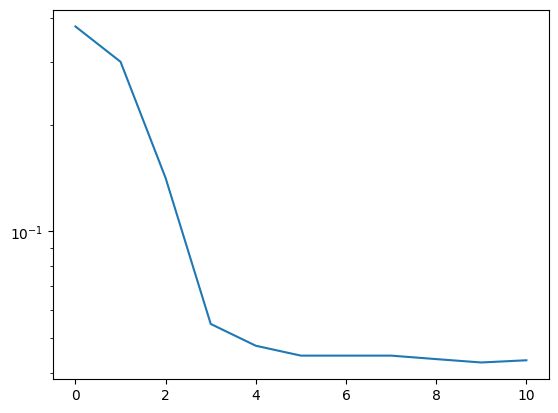

In [11]:
from optimize_2D import optimize

Vlist, f_iter, err_iter = optimize(L, U, Vlist_start, perms_extended, niter=10)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [12]:
with h5py.File(f"./results/tfim2d_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_U_3hloc_v2.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [37]:
#Vlist = []
#with h5py.File("./results/tfim2d_101_Lx3Ly3_t0.25_layers9_U_v3.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

with h5py.File(f"./results/tfim2d_{J}{h}{g}_Lx3Ly3_t{t}_layers9_U_3hloc_v2.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]

In [38]:
from scipy.sparse.linalg import expm_multiply

perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
perms_extended = [perms_v, perms_v, perms_v, perms_h, perms_h, perms_h, perms_v, perms_v, perms_v]

Lx, Ly = (3, 3)
L = Lx*Ly
t = 0.25
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

state = np.array(random_statevector(2**L).data)
print("Trotter error: ", np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))

Trotter error:  0.014658279834763598


In [39]:
"""
    Scaling from 3x3 -> 4x4. Important proof of concept! 
"""


from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import state_fidelity

perms_v = [[0, 1, 4, 5, 8, 9, 12, 13, 2, 3, 6, 7, 10, 11, 14, 15], 
          [1, 2, 5, 6, 9, 10, 13, 14, 3, 0, 7, 4, 11, 8, 15, 12]]
perms_h = [[0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
          [4, 8, 5, 9, 6, 10, 7, 11, 12, 0, 13, 1, 14, 2, 15, 3]]
perms_extended = [perms_v, perms_v, perms_v, perms_h, perms_h, perms_h, perms_v, perms_v, perms_v]

Lx, Ly = (4, 4)
L = Lx*Ly
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

state = np.array(random_statevector(2**L).data)
print("Trotter error: ", np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))

Trotter error:  0.019069131740793995


In [23]:
"""
    Attempt for the controlled version:
"""

import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_ansatz_2D")
from utils_2D import construct_ising_local_term, reduce_list, X, I2
from ansatz_2D import ansatz_2D, ansatz_sparse
import rqcopt as oc

Lx, Ly = (2, 2)
L = Lx*Ly
t = 0.25
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()
eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])

hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)/2
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4
V1 = scipy.linalg.expm(-1j*t*hloc1/2)
V2 = scipy.linalg.expm(-1j*t*hloc2)
V3 = scipy.linalg.expm(-1j*t*hloc1/4)
V4 = scipy.linalg.expm(-1j*t*hloc2/2)
YZ = np.kron(Y, Z)

perms_v = [[0, 1, 2, 3], [1, 0, 3, 2]]
perms_h = [[0, 2, 1, 3], [2, 0, 3, 1]]

Vlist_start = [YZ, V3, V4, V3, YZ, YZ, V1, V2, V1, YZ, YZ, V3, V4, V3, YZ]
Vlist_reduced = [V3, V4, V3, V1, V2, V1, V3, V4, V3]
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3
control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers

U = scipy.linalg.expm(-1j*hamil*t)
U_back = scipy.linalg.expm(1j*hamil*t)
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_2D(Vlist_start, L, perms_extended) - U_back, ord=2) +\
                                                np.linalg.norm(ansatz_2D(Vlist_reduced, L, perms_ext_reduced) - U, ord=2)
                                               )/2)

Trotter error of the starting point:  0.13347188641887073


0.006405958437971454


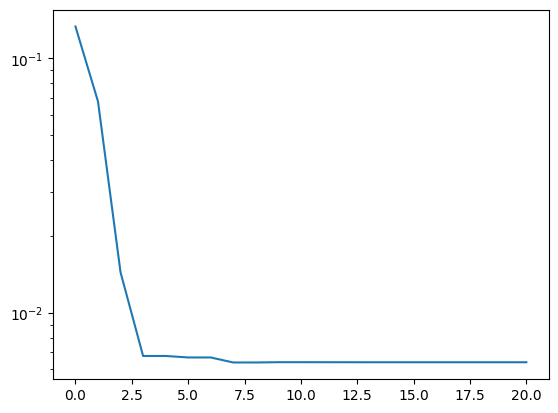

In [24]:
from optimize_2D import optimize

Vlist, f_iter, err_iter = optimize(L, U, Vlist_start, perms_extended, perms_reduced=perms_ext_reduced, 
                                   control_layers=control_layers, niter=20)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [33]:
Lx, Ly = (4, 4)
L = Lx*Ly
t = 0.25
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()


perms_v = [[0, 1, 4, 5, 8, 9, 12, 13, 2, 3, 6, 7, 10, 11, 14, 15], 
          [1, 2, 5, 6, 9, 10, 13, 14, 3, 0, 7, 4, 11, 8, 15, 12]]
perms_h = [[0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
          [4, 8, 5, 9, 6, 10, 7, 11, 12, 0, 13, 1, 14, 2, 15, 3]]
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3
control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers


Vlist_reduced = []
for i, V in enumerate(Vlist):
    if i not in control_layers:
        Vlist_reduced.append(V)
#U = scipy.linalg.expm(-1j*hamil*t)
#U_back = scipy.linalg.expm(1j*hamil*t)
"""print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, reps=len(perms_v)) - U_back, ord=2) +\
                                                np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, reps=len(perms_v)) - U, ord=2)
                                               )/2)"""

state = np.array(random_statevector(2**L).data)
print("Trotter error: ", (np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2)))
      
print(np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))


Trotter error:  0.5750621139281873
0.5751317605441435
